# Convolutional Neural Networks

### Introduction

In this notebook 'cnn_from_scratch.ipynb', we'll create and train a CNN from scratch that classifies landmarks.
The aim is to determine the accuracy one can achieve compared to the state of the art models which is explored in the notebook 'transfer_learning.ipynb' 

Experimenting with different architectures, hyperparameters, training strategies, and most of all testing one's intuition is the ultimate goal.

In [ ]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

In [ ]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

---
### 1: Testing Data Loaders

In [2]:
!pytest -vv src/data.py -k data_loaders

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 1 deselected / 3 selected                                  

src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

======================= 3 passed, 1 deselected in 10.92s =======================


### Data Preprocessing

- All images are first resized to 256 pixels that preserves the aspect ratio
- Training: random cropping and mild scaling (slight stretching or compression is possible but kept minimal)
- Val/Test: Takes a centered 224×224 crop from the resized 256×256 image. No stretching or distortion. The final input tensor size is 224 × 224 × 3 (standard input size for most pre-trained models in torchvision, best for transfer learning)
- Heavily augment the training data to make the model more robust to real-world variations in landmark photos like different angles, lighting

### Visualize a Batch of Training Data

In [3]:
!pytest -vv src/data.py -k visualize_one_batch

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 3 deselected / 1 selected                                  

src/data.py::test_visualize_one_batch PASSED                             [100%]

======================= 1 passed, 3 deselected in 8.31s ========================


We can now use the code to get a batch of images from train data loader and look at them

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


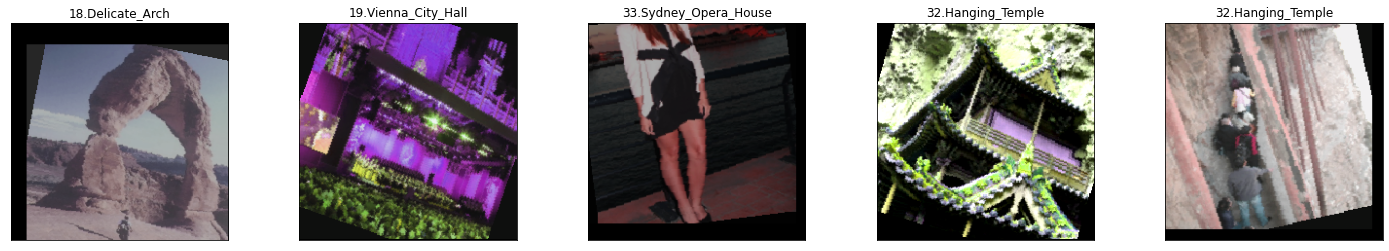

In [ ]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(batch_size=5, num_workers=4)

visualize_one_batch(data_loaders)

### 2: Testing the model implementation

In [3]:
!pytest -vv src/model.py

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 1 item                                                               

src/model.py::test_model_construction PASSED                             [100%]

============================== 1 passed in 9.87s ===============================


### 3: Test loss & optimizer

In [6]:
!pytest -vv src/optimization.py -k get_loss

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 7 items / 6 deselected / 1 selected                                  

src/optimization.py::test_get_loss PASSED                                [100%]

======================= 1 passed, 6 deselected in 1.55s ========================


In [7]:
!pytest -vv src/optimization.py -k get_optimizer

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 7 items / 1 deselected / 6 selected                                  

src/optimization.py::test_get_optimizer_type PASSED                      [ 16%]
src/optimization.py::test_get_optimizer_is_linked_with_model PASSED      [ 33%]
src/optimization.py::test_get_optimizer_returns_adam PASSED              [ 50%]
src/optimization.py::test_get_optimizer_sets_learning_rate PASSED        [ 66%]
src/optimization.py::test_get_optimizer_sets_momentum PASSED             [ 83%]
src/optimization.py::test_get_optimizer_sets_weight_decat PASSED         [100%]

======================= 6 passed, 1 deselected in 1.45s ========================


In [ ]:
!pytest -vv src/train.py -k train_one_epoch

In [ ]:
!pytest -vv src/train.py -k valid_one_epoch

In [ ]:
!pytest -vv src/train.py -k optimize

In [ ]:
!pytest -vv src/train.py -k one_epoch_test

## Train & Validate

In [ ]:
batch_size = 64        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
num_epochs = 40        # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.4          # dropout for our model
learning_rate = 0.01   # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.0001  # regularization
momentum=0.9

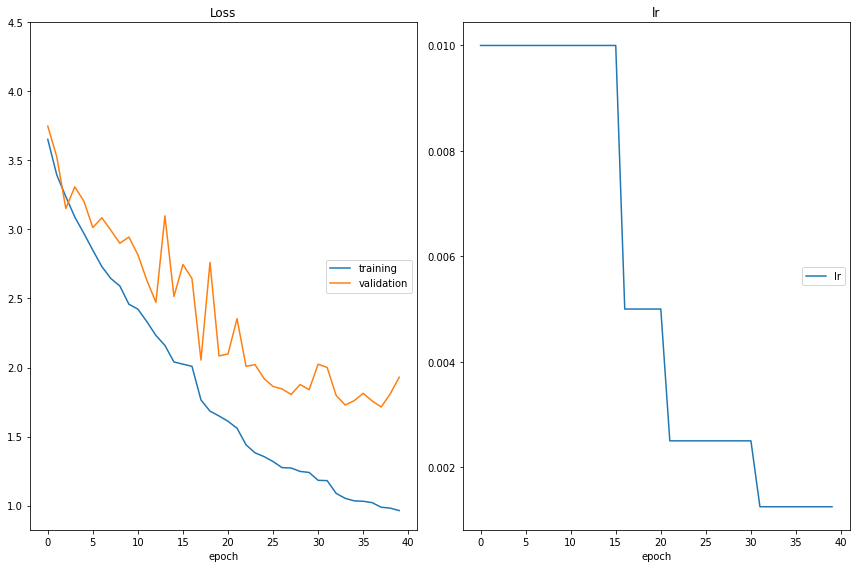

In [ ]:
from src.data import get_data_loaders
from src.train import optimize, one_epoch_test
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# get the data loaders using batch_size and valid_size defined in the previous
data_loaders = get_data_loaders(batch_size=batch_size, valid_size=valid_size)

# instance model MyModel with num_classes and drouput
model = MyModel(num_classes=num_classes, dropout=dropout)

# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(model, optimizer=opt, learning_rate=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Get the loss using get_loss
loss = get_loss()

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoint/best_val_loss.pt",
    interactive_tracking=True
)

## Small Testing

In [ ]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)
model.load_state_dict(torch.load('checkpoint/best_val_loss.pt', map_location=torch.device('cpu')))
model.eval()
# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:15<00:00,  1.29it/s]

Test Loss: 1.646692


Test Accuracy: 58% (730/1250)


1.6466922730207443

## Exporting the model

- Test predictor class

In [4]:
!pytest -vv src/predictor.py

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 1 item                                                               

src/predictor.py::test_model_construction PASSED                         [100%]

============================== 1 passed in 10.34s ==============================


In [ ]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.3).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training

model.load_state_dict(torch.load('checkpoint/best_val_loss.pt', map_location=torch.device('cpu')))
model.eval()

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)

scripted_predictor.save("checkpoint/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


## Full Testing & Performance Accuracy 

In [ ]:
import torch

# Load using torch.jit.load
model_reloaded = torch.jit.load("checkpoint/original_exported.pt")

In [6]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

100%|███████████████████████████████████████| 1250/1250 [07:28<00:00,  2.79it/s]

Accuracy: 0.5344


### Viusalizing the confusion matrix of the model

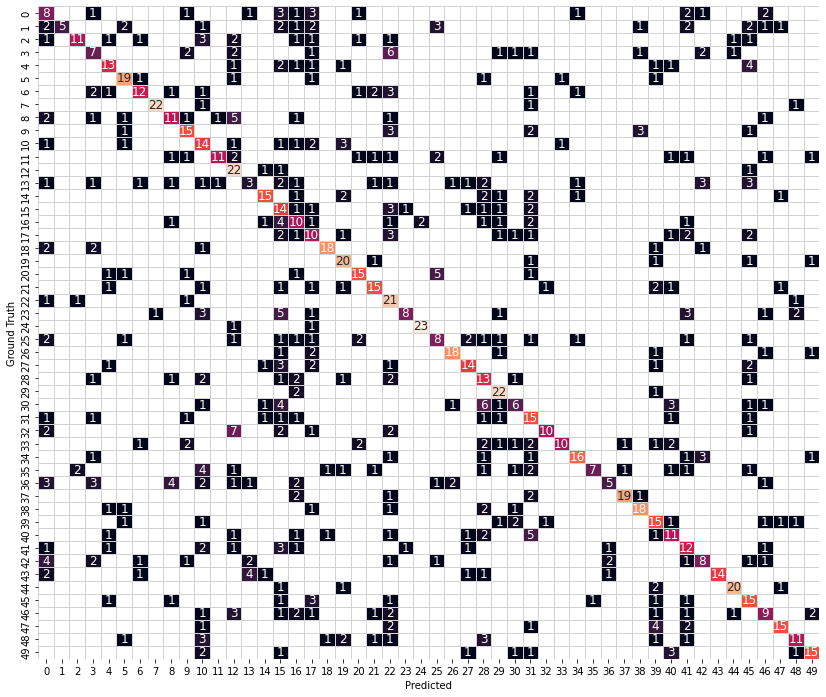

In [7]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)